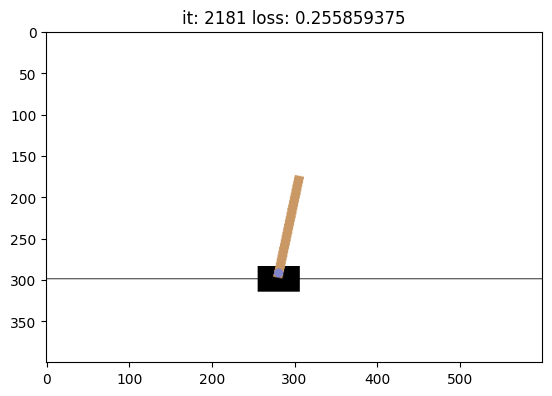

In [1]:
from typing import Tuple
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from multipath.nn.modules import Decoder
import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import torch._dynamo

env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
observation, info = env.reset(seed=42)


class Agent(nn.Module):

    def __init__(self, hidden_size: int, num_layers: int, num_actions: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_actions = num_actions

        self.actor = nn.Linear(hidden_size, num_actions)
        self.action_embeds = nn.Embedding(num_embeddings=num_actions, embedding_dim=hidden_size)
        self.state_embeds = nn.Linear(in_features=5, out_features=hidden_size)
        self.decoder = Decoder(hidden_size=hidden_size, num_layers=num_layers, dropout=0.5)
        self.state_head = nn.Linear(in_features=hidden_size, out_features=5)
        self.action_head = nn.Linear(in_features=hidden_size, out_features=num_actions)
    
    def actor_forward(self, states: Tensor, actions: Tensor) -> Tensor:
        
        self.action_embeds.requires_grad_(False)
        self.state_embeds.requires_grad_(False)
        self.decoder.requires_grad_(False)
        self.state_head.requires_grad_(False)
        
        state_embeds = self.state_embeds(states)
        action_embeds = self.action_embeds(actions)
        last_act = self.actor(state_embeds[:,-1,:])
        last_act_embeds = last_act @ self.action_embeds.weight
        action_embeds[:,-1] = last_act_embeds

        
        input_embeds = torch.cat([action_embeds, state_embeds], dim=-1)
        output, _ = self.decoder(input_embeds)
        state_output = output[...,:self.hidden_size]
        action_output = output[...,self.hidden_size:]
        state_logits = self.state_head(state_output)
        #action_logits = self.action_head(action_output)
        last_state_logits = state_logits[:,-1,-1]
        return last_act, last_state_logits


    def forward(self, states: Tensor, actions: Tensor) -> Tuple[Tensor, Tensor]:
        self.action_embeds.requires_grad_(True)
        self.state_embeds.requires_grad_(True)
        self.decoder.requires_grad_(True)
        self.state_head.requires_grad_(True)
        action_embeds = self.action_embeds(actions)
        state_embeds = self.state_embeds(states)
        input_embeds = torch.cat([action_embeds, state_embeds], dim=-1)
        output, _ = self.decoder(input_embeds)
        state_output = output[...,:self.hidden_size]
        action_output = output[...,self.hidden_size:]
        state_logits = self.state_head(state_output)
        action_logits = self.action_head(action_output)
        
        return state_logits, action_logits

observations = []
actions = []
labels = []

agent = Agent(hidden_size=32, num_layers=4, num_actions=2).to(torch.bfloat16).to('cuda')
opt = optim.Adam(agent.parameters(), lr=1e-4, weight_decay=1e-5, betas=(0.9, 0.96),fused=True)
action = None


for i in range(100000):
    if i < 1000:
        action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    observation = np.concatenate([observation, [float(terminated)]])
    observations.append(observation)
    actions.append(action)

    o = torch.as_tensor(observations, dtype=torch.bfloat16).to(device='cuda').unsqueeze(0)
    a = torch.as_tensor(actions, dtype=torch.long).to('cuda').unsqueeze(0)
    loss = float('nan')
    if o.shape[1] > 2:
        agent.train()
        oh, ah = agent(o, a)
        loss = F.mse_loss(oh[:, :-1, :-1], o[:, 1:, :-1])+ F.binary_cross_entropy_with_logits(oh[:, :-1, -1], o[:, 1:, -1])  + F.cross_entropy(ah[:, :-1].flatten(0, 1), a[:, 1:].view(-1))
        #last_act, actor_logits = agent.actor_forward(o, a)
        #loss += F.binary_cross_entropy_with_logits(actor_logits, torch.zeros_like(actor_logits))
        opt.zero_grad()
        loss.backward()
        opt.step()
        if i >= 1000:
            action = torch.argmax(ah[:, -1], dim=-1).item()
        loss = loss.item()

    frame = env.render()
    clear_output(wait=True)
    plt.imshow(frame)
    plt.title(f'it: {i} loss: {loss}')
    plt.show()
    if terminated or truncated:
        observation, info = env.reset()
        observations = []
        actions = []
env.close()

In [2]:
import torch
a = torch.randint(0, 100, (2, 10, 10))

In [5]:
a[0 ]

tensor([[21, 52, 93, 85, 56, 31, 64, 22, 69, 12],
        [ 2, 33, 41, 66, 66, 64, 16, 24, 89, 64],
        [24, 59, 79, 26, 28, 23, 14, 77, 35, 33],
        [79, 71, 61, 59, 27, 48, 71, 19, 26, 95],
        [88, 39, 81, 22, 58, 69, 19, 23, 43, 82],
        [25, 95, 92, 94, 96, 95, 86, 36, 85, 32],
        [31, 31, 96, 23, 73, 41, 67, 61, 87, 63],
        [50, 23,  5, 63, 23, 92, 64, 87, 20, 79],
        [48, 38, 91, 59, 96, 66, 59, 65, 94, 67],
        [70, 58,  6, 37, 68, 42, 29, 54, 12, 81]])

In [6]:
a.view(2, 5, 2, 10)[0]

tensor([[[21, 52, 93, 85, 56, 31, 64, 22, 69, 12],
         [ 2, 33, 41, 66, 66, 64, 16, 24, 89, 64]],

        [[24, 59, 79, 26, 28, 23, 14, 77, 35, 33],
         [79, 71, 61, 59, 27, 48, 71, 19, 26, 95]],

        [[88, 39, 81, 22, 58, 69, 19, 23, 43, 82],
         [25, 95, 92, 94, 96, 95, 86, 36, 85, 32]],

        [[31, 31, 96, 23, 73, 41, 67, 61, 87, 63],
         [50, 23,  5, 63, 23, 92, 64, 87, 20, 79]],

        [[48, 38, 91, 59, 96, 66, 59, 65, 94, 67],
         [70, 58,  6, 37, 68, 42, 29, 54, 12, 81]]])

In [20]:
import torch 

x = torch.randn(10, 10)
y = torch.randn(10, 10)


a1 = x @ y
a2 = y @ x

In [22]:
a1

tensor([[ 6.6177,  3.5967,  0.8464, -2.7326,  1.6867,  1.8260, -0.1615,  0.3334,
          2.6924,  5.5618],
        [ 3.2056,  4.0359,  5.5721, -1.5209,  3.2669,  0.4057,  0.0420,  1.2967,
          1.9426, -0.2822],
        [ 4.6053,  3.1358,  4.3651, -1.4106,  3.9750,  0.5043, -0.7469, -0.8910,
          1.4379,  3.1478],
        [-4.4724, -5.4141, -4.5952, -2.2043, -1.5682, -0.8439,  0.3322,  3.2133,
         -8.2828, -0.2051],
        [ 0.2019, -7.2652, -3.4209,  0.0840, -5.3545,  0.3786, -3.3877,  2.8966,
          8.0053, -1.3969],
        [ 0.7664,  1.8462,  2.5880, -1.8352,  2.9587, -0.9766, -2.5515,  0.0218,
         -2.6426, -1.5378],
        [-6.4194,  2.4143, -3.7583,  1.5247, -2.6122, -2.3710, -2.9155, -0.0705,
          2.1054, -0.3533],
        [-3.9979, -3.0035,  0.6465, -1.2182, -7.2889, -4.3089, -7.6175,  3.4944,
          0.9602, -4.5646],
        [-0.6309,  2.8748,  4.1314, -1.3215,  2.1021, -0.5827,  0.0763,  2.4243,
          0.1626, -0.4015],
        [-0.2891,  

In [23]:
a2

tensor([[  3.8252,  10.3113,  -4.8511,   0.7109,  -5.4236,  -3.5305,   0.5497,
           0.3335,   1.9964,  -1.3413],
        [  0.9967,   6.0988,  -1.7668,   5.1792,   3.2541,   6.8511,  -2.5665,
           1.3816,   0.1862,  -0.1210],
        [ -1.4821,  -1.8540,   0.2966,   0.1367,   2.3184,   3.8873,  -1.3453,
           0.4609,  -2.1354,   0.4459],
        [  2.6260,   3.1155,  -0.8254,   2.8183,  -0.3256,  -3.2909,  -4.2023,
           0.0431,   5.4810,  -0.0459],
        [  0.3856,  -1.2118,  -0.4427,  -1.1447,   1.5151,   3.1608,  -2.3957,
          -1.2432,  -2.1253,   0.2360],
        [ -2.7675,   1.8975,  -1.6656,   1.7130,   1.0629,  -3.9911,   1.5724,
          -1.5045,   0.6284,   0.2207],
        [ -3.0772,  -1.6785,   0.9477,  -2.3442,  -3.0447,  -2.3892,   5.9087,
          -0.8974,  -2.5842,  -1.7850],
        [ -1.0402,  -0.0434,   3.7422,  -0.9279,  -0.0998, -10.4818,   3.7526,
          -0.5620,   4.9364,   3.1723],
        [ -0.0329,   4.2495,  -5.0697,  -0.3510,